## CUNY DATA622 - Zachary Herold

### Part I. China B Share Index Replication using XGBRegressor()

There is a small market of 49 USD-denominated Chinese equities, comprising approximately USD 24.2 billion in market capitalization (as of November 29, 2019), sparsely traded on the Shanghai Stock Exchange. Reflecting the price movements of these 'B-shares' is the SSE B Share Index (000003.SS).

The SSE B Share Index construction methodology employs market-capitalization weighting and is outlined here:

概要：上证B股指数的样本股是全部上市B股，反映了B股的股价整体变动状况，自1992年8月17日起正式发布。 
基期及基点：1992.02.21 ＝100 指数计算：以样本股的发行股本数为权数进行加权计算，计算公式为：

报告期指数 ＝ 报告期成份股的总市值 / 基期 × 基期指数；

其中，总市值 = ∑(市价×发行股数)。 
样本选择标准：上海证券交易所挂牌上市的全部B股股票。
自20070106起，新股于上市第十一个交易日开始计入指数

Source: http://vip.stock.finance.sina.com.cn/corp/go.php/vII_BasicInfo/indexid/000003.phtml

To reconstitute the index, one must know both the base value of each individual stock component at the time of index inclusion, as well as the timing and quantity of each secondary public offering, dividend share offering, stock option exercise, and stock buyback. While this data may be publicly available, the index construction methodology is rather opaque and cumbersome.   

Given the importance of having an effective market benchmark, the aim of this project is to replicate the SSE B Share Index from historial price and floating share data by performing feature selection with L1 regularization. 

In [46]:
#Importing packages
import pandas as pd
import numpy as np 
from numpy import sort
import matplotlib.pyplot as plt
from datetime import datetime as dt
import re
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

# from sklearn import ensemble
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.pipeline import Pipeline

np.set_printoptions(precision=3, suppress=True)

### Self-defined functions

In [2]:
# We wish to construct a pivot table with all the individual stock prices and shares outstanding as 
# features. To do so, we create a function which first melts the data into long format, then uses 
# the pivot_table method to widen it. While doing so, we remove all zero values.  

def create_pivot_table(data):
    data = pd.melt(data, id_vars=['date','ticker'], var_name='metrics', value_name='value')
    data['metric'] = data['ticker'].map(str) +'-'+ data['metrics']
    data = data.drop(['ticker','metrics'], axis=1)
    data = data[data.value != 0]
    data = data.reset_index().pivot_table(index='date', columns='metric', values='value')
    return data

In [3]:
def draw_prediction_graph(p):
    fig, ax = plt.subplots()
    ax.scatter(y_test, p, edgecolors=(0, 0, 0))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title("Ground Truth vs Predicted")
    plt.show()

### Historical data load, imputation, merge and conversion to pivot table

In [4]:
# Loading 10-year historical and stock profile data collected by the author online from public sources.
# The data was cleaned and exported from Postgresql separately. 

data_url1 = 'https://raw.githubusercontent.com/ZacharyHerold/CUNY-DATA622/master/FinalProject/bshare_sh_10yr'
data_url2 = 'https://raw.githubusercontent.com/ZacharyHerold/CUNY-DATA622/master/FinalProject/stock_profile.csv'
raw_data1 = pd.read_csv(data_url1, sep=';')
raw_data2 = pd.read_csv(data_url2, sep=';')

In [5]:
# We gather date, ticker, and closing price data, simplistically assuming that the shares outstanding has historically 
# been the same as the amount of record date (November 29, 2019).

df_daily = raw_data1[['date','ticker','close']]
df_profile = raw_data2[['ticker','shares_outstanding_b']]
df = df_daily.merge(df_profile, on='ticker')
df.columns = ['date','ticker','close','float']
#df.head()

In [6]:
df2 = create_pivot_table(df)
df2.head(5)

metric,900901-close,900901-float,900902-close,900902-float,900903-close,900903-float,900904-close,900904-float,900905-close,900905-float,...,900952-close,900952-float,900953-close,900953-float,900955-close,900955-float,900956-close,900956-float,900957-close,900957-float
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.556,293.3705,0.443,465.85,0.816,800.8065,0.811,54.7517,1.915,206.0081,...,0.480,222.807,0.719,240.0,0.705,330.0,0.798,115.0,0.546,184.0
2010-01-05,0.563,293.3705,0.443,465.85,0.833,800.8065,0.813,54.7517,1.932,206.0081,...,0.485,222.807,0.739,240.0,0.695,330.0,0.810,115.0,0.542,184.0
2010-01-06,0.558,293.3705,0.441,465.85,0.824,800.8065,0.814,54.7517,1.918,206.0081,...,0.482,222.807,0.754,240.0,0.708,330.0,0.809,115.0,0.546,184.0
2010-01-07,0.544,293.3705,0.434,465.85,0.816,800.8065,0.795,54.7517,1.888,206.0081,...,0.476,222.807,0.745,240.0,0.705,330.0,0.793,115.0,0.528,184.0
2010-01-08,0.556,293.3705,0.436,465.85,0.831,800.8065,0.805,54.7517,1.890,206.0081,...,0.481,222.807,0.750,240.0,0.714,330.0,0.792,115.0,0.528,184.0


In [7]:
# We observe a number of null values
null_counts = df2.isnull().sum()
null_counts.sort_values(ascending=False).head(5)

metric
900940-close    472
900940-float    427
900907-close    365
900946-close    340
900938-close    340
dtype: int64

In [8]:
# Imputing null values as 0.
df2.fillna(0, inplace = True)

In [9]:
# (1) Loading the target data -- the Shanghai B-share Index values. 
data_url3 = 'https://raw.githubusercontent.com/ZacharyHerold/CUNY-DATA622/master/FinalProject/000003.csv'
raw_data3 = pd.read_csv(data_url3, sep=';')
ix = raw_data3[['date','close']]

# (2) Merging the Index closing values with the pivot table to ensure alignment of dates.
df3 = df2.merge(ix, on='date')

# (3) Setting the date as the index
df3.set_index('date', inplace=True)

In our index replication, we wish to engage in feature selection. We expect an end model with closing prices as predictors and regression coefficients approximating the (cap/float-based) weighting of the index construction. XGBRegressor() is the appropriate choice as it is the only gradient booster in the XGBoost package to compute coefficients that can be used in model construction. 

To do so, we first try to build the model with the lowest mean squared error using XGBoost's  gblinear.

As an experiment, we use the xgb.train() API with the booster gbtree, with maximum depth of 3 and 20 boosting rounds, then plot the features by importance. We learn that the none of the floating-share attributes made it to the model, even after rescaling with the StandardScaler().fit_transform() method. 

Most important stocks after boosting at max-depth 2:
10-boosts: 900957, 900908, 900941, 900914
20-boosts: 900957, 900908
30-boosts: 900957, 900920, 900908, 900910
40-boosts: 900957, 900908, 900910

Most important stocks after boosting at max-depth 3:
10-boosts: 900957, 900941, 900908
20-boosts: 900948, 900908, 900941, 900957
30-boosts: 900919, 900957, 900948, 900908
40-boosts: 900948, 900919, 900957, 900908

Most important stocks after boosting at max-depth 4:
10-boosts: 900903, 900957, 900908
20-boosts: 900919, 900957
30-boosts: 900948, 900903, 900905, 900908
40-boosts: 900948, 900903, 900908

One of the stocks is expected: Inner Mongolia Yitai Coal, which is dually listed in Hong Kong and is typically the most actively traded stock on the exchange. However, the two other most frequently appearing stocks are a surpise - Shanghai Chlor-Alkali Chemical and Shanghai Lingyun Industries - as they are hardly among the leaders in terms of market capitalization or number of floating shares. 

In [10]:
raw_data2[raw_data2.ticker.isin([900957,900908, 900948])][['ticker','name_b','company_name_en']]

,ticker,name_b,company_name_en
6,900908,氯碱B股,Shanghai Chlor-Alkali Chemical
42,900948,伊泰B股,Inner Mongolia Yitai Coal
48,900957,凌云B股,Shanghai Lingyun Industries


In [11]:
# Preparing the data for XGBoost
X = df3.iloc[:,:-1]
y = np.ravel(df3.iloc[:,-1])

### Feature Selection with xgb.train() and xgb.plot_importance()

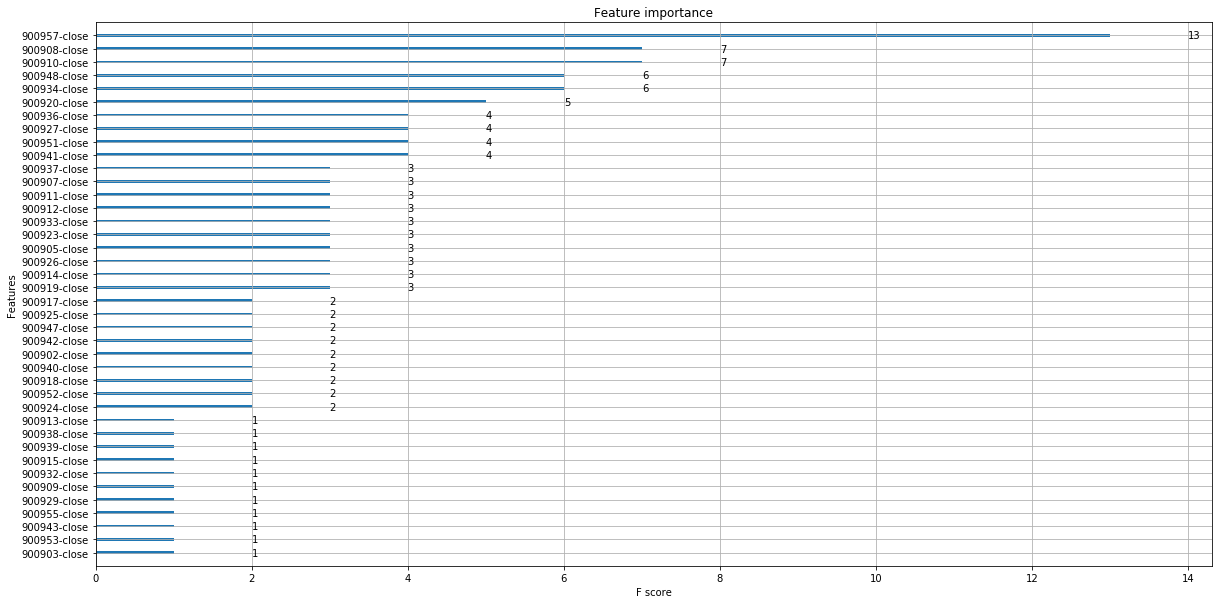

In [12]:
b_matrix = xgb.DMatrix(data=X, label=y)
params = {"booster": "gbtree", "objective":"reg:squarederror", "max_depth":2}
model1 = xgb.train(params=params, dtrain=b_matrix, num_boost_round=40)
fig, ax = plt.subplots(figsize=(20, 10))
xgb.plot_importance(model1, ax=ax)
plt.show()

Given the overwhelming lack of feature importance assigned to the floating shares, they are removed in the next trial of XGBoosting, this time using XGBRegressor().

In [13]:
df = df.drop('float', axis=1)

In [14]:
df2 = create_pivot_table(df)
df3 = df2.merge(ix, on='date')
df3.set_index('date', inplace=True)

In [15]:
# Preparing the data for XGBoost
X = df3.iloc[:,:-1]
y = np.ravel(df3.iloc[:,-1])

# Resolving infinity and None values
X.replace(np.inf, np.nan, inplace=True)
X.fillna(0, inplace=True)

In [16]:
# Splitting samples 80/20 into training and test sets in order to calculate loss via root of mean squared error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

### Tree boosting with GridSearch CV

We use GridSearchCV from the sklearn.model_selection module to tune a variety of hyperparameters for candidate XGBRegressor models. A collection of RMSE scores are provided below, with variations in maximum depth, number of estimators and L1 normalization alpha. 

Best parameters found:  {'max_depth': 4, 'n_estimators': 20, 'reg_alpha': 0.8}
Lowest RMSE found:  49.7074637875266
    
Best parameters found:  {'max_depth': 4, 'n_estimators': 40, 'reg_alpha': 0.8}
Lowest RMSE found:  28.341556472431115

Best parameters found:  {'max_depth': 3, 'n_estimators': 20, 'reg_alpha': 0.8}
Lowest RMSE found:  49.29693159747133

Best parameters found:  {'max_depth': 3, 'n_estimators': 20, 'reg_alpha': 0.2}
Lowest RMSE found:  49.13339975755375
    
Best parameters found:  {'max_depth': 3, 'n_estimators': 40, 'reg_alpha': 0.1}
Lowest RMSE found:  28.04693737341386

Best parameters found:  {'max_depth': 3, 'n_estimators': 40, 'reg_alpha': 0.8}
Lowest RMSE found:  31.117147351891198

Best parameters found:  {'max_depth': 2, 'n_estimators': 20, 'reg_alpha': 0.1}
Lowest RMSE found:  51.35253146994165

Best parameters found:  {'max_depth': 2, 'n_estimators': 40, 'reg_alpha': 0.8}
Lowest RMSE found:  29.812441095775487

In [17]:
gbm_param_grid = {
    'n_estimators': np.arange(20,45,5),
    'max_depth': [3],
    'reg_alpha': [0.2, 0.8, 0.2] 
}
# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(objective='reg:squarederror')
# Perform grid search: grid_mse
grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, scoring="neg_mean_squared_error", cv=4,verbose=1)
# Fit grid_mse to the data
grid_mse.fit(X,y)
# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   19.0s finished
c:\python\python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters found:  {'max_depth': 3, 'n_estimators': 40, 'reg_alpha': 0.8}
Lowest RMSE found:  31.117147351891198


### Note on L1 Regularization

Since our aim is to engage in feature selection, we require high alpha closer to 1. We observe that the main driver for differences in RMSE is the number of estimators. The default booster of gbtree yields excessive loss when the number of estimators is 20, as opposed to 40. 

L1 regularization adds a penalty to the loss function (L1-norm). Since each non-zero coefficient adds to the penalty, it forces weak features to have zero as coefficients. Thus L1 regularization produces sparse solutions, inherently performing feature selection. 

### Linear Boosting

We observe a decrease in RMSE when using a linear booster, even with the level of estimators at 20, suggesting that a strong linear component in the ground truth, as is expected in a market-cap weighted index.  

reg_alpha=0.8, n_estimators=20 ----> RMSE: 16.54346

In [19]:
model2 = xgb.XGBRegressor(dtrain=dmatrix, booster='gblinear', reg_alpha=0.8, n_estimators=20, objective="reg:squarederror")
model2.fit(X_train, y_train)
preds2 = model2.predict(X_test)

mse2 = mean_squared_error(preds2, y_test)
print("RMSE: %.5f" % (np.sqrt(np.abs(mse2))))

RMSE: 16.54346


### Visualizing Ground Truth vs. Predicted Index Values

We observe that our predicted values tend to be below the identity line, revealing that our model underestimates the index value, especially when it is above 270. 

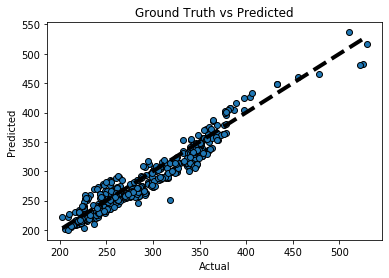

In [20]:
draw_prediction_graph(preds2)

### Regression Coefficient Extraction

When we extract the regression coefficients from XGBRegressor(), we fail to discover the feature selection we expected, with all 49 coefficients well above 0. We note the stocks that are most heavily weighted under this method, and compare the results after the historical data has been standardized using StandardScaler() below. 

In [21]:
features = X.columns
coef2 = model2.coef_
reg2 = pd.DataFrame(list(zip(features,coef2)), columns=['feature','coef_alpha_0.8'])
reg2 = reg2.sort_values(by = 'coef_alpha_0.8', ascending=False)
[reg2.max(), reg2.min()]

[feature           900957-close
 coef_alpha_0.8         9.26289
 dtype: object, feature           900901-close
 coef_alpha_0.8        0.798083
 dtype: object]

In [22]:
reg2.head(10)

,feature,coef_alpha_0.8
4,900905-close,9.26289
9,900911-close,7.90691
3,900904-close,7.69222
12,900914-close,7.04920
21,900923-close,7.02874
10,900912-close,6.97406
29,900933-close,6.91626
23,900925-close,6.88708
7,900909-close,6.42843
20,900922-close,6.17458


In [23]:
## Most heavily weighted stocks in index construction with non-standardized data. 
raw_data2[raw_data2.ticker.isin([900905,900911, 900904, 900914, 900923, 900912, 900933, 900925, 900909, 900922])][['ticker','name_b','company_name_en']]

,ticker,name_b,company_name_en
3,900904,神奇B股,Shanghao Shenqi Pharmaceutical
4,900905,老凤祥B,Lao Feng Xiang
7,900909,华谊B股,Shanghai Huayi Group
9,900911,金桥B股,Shanghai Jinqiao Development
10,900912,外高B股,Shanghai Waigaoqiao Development
12,900914,锦投B股,Shanghai Jinjiang Investment
20,900922,三毛B股,Shanghai Sanmao Enterprise
21,900923,百联B股,Shanghai Bailian Group
23,900925,机电B股,Shanghai Mechanical & Electrical
29,900933,华新B股,Huaxin Cement


### Rescaling the data with StandardScaler()

In [24]:
rescaled_X = StandardScaler().fit_transform(X)
y = np.array(y)
y = y.reshape(-1, 1)
rescaled_y = StandardScaler().fit_transform(y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(rescaled_X, rescaled_y, test_size = 0.2, random_state=123)

In [26]:
model3 = xgb.XGBRegressor(dtrain=dmatrix, booster='gblinear', reg_alpha=0.8, n_estimators=20, objective="reg:squarederror")
model3.fit(X_train, y_train)
preds3 = model3.predict(X_test)

mse3 = mean_squared_error(preds3, y_test)
print("RMSE: %.5f" % (np.sqrt(np.abs(mse3))))

RMSE: 0.94416


In [27]:
#After scaling, feature selection occurs, producing 7 stocks for index inclusion.
coef3 = model3.coef_
reg3 = pd.DataFrame(list(zip(features,coef3)), columns=['feature','coef_alpha_0.8'])
reg3 = reg3.sort_values(by = 'coef_alpha_0.8', ascending=False)
reg3.head(15)

,feature,coef_alpha_0.8
48,900957-close,0.017207
6,900908-close,0.015913
27,900929-close,0.015885
36,900941-close,0.014758
12,900914-close,0.007279
4,900905-close,0.006750
45,900953-close,0.002323
38,900943-close,0.000126
34,900939-close,0.000122
43,900951-close,0.000071


In [28]:
## Most heavily weighted stocks in index construction with standardized data using XGBRegressor(). 
raw_data2[raw_data2.ticker.isin([900957,900908, 900929, 900941, 900914, 900905, 900953])][['ticker','name_b','company_name_en']]

,ticker,name_b,company_name_en
4,900905,老凤祥B,Lao Feng Xiang
6,900908,氯碱B股,Shanghai Chlor-Alkali Chemical
12,900914,锦投B股,Shanghai Jinjiang Investment
27,900929,锦旅B股,Shanghai Jinjiang Travel
36,900941,东信B股,Eastern Communications
45,900953,凯马B,Kama Co
48,900957,凌云B股,Shanghai Lingyun Industries


It is interesting to note that we see 900908 and 900957, as we unexpectedly did when we performed the initial feature selection using xgb.train and the gbtree booster. It may be the case that these two stocks have a beta close to 1. 900905, LaoFengXiang, the most expensive stock on the market, and the Jinjiang stocks (900914, 900929) are mainstream stocks we would expect as heavy contributors to the index. 

### Using sklearn.model_selection's Lasso 

Finally, we wish to compare the XGBRegressor results with alpha regularization to the Scikit-Learn Lasso model, which also employs L1 regularization. Lasso requires scaling and the feature selection is much more apparent, with 4 non-zero stocks. 

The RMSE with Lasso of 0.92500 compares favorable to XGBRegressor's score of RMSE: 0.94416, but they both are far too high in consideration that they are standardized values. 

In [29]:
model4 = Lasso(alpha=0.8)
model4.fit(X_train, y_train)
preds4 = model4.predict(X_test)

mse4 = mean_squared_error(preds4, y_test)
print("RMSE: %.5f" % (np.sqrt(np.abs(mse4))))

RMSE: 0.92500


In [30]:
coef4 = model4.coef_
reg4 = pd.DataFrame(list(zip(features,coef4)), columns=['feature','coef_alpha_0.8_lasso'])
reg4 = reg4.sort_values(by = 'coef_alpha_0.8_lasso', ascending=False)
reg4.head(8)

,feature,coef_alpha_0.8_lasso
48,900957-close,0.047838
36,900941-close,0.022310
6,900908-close,0.019692
27,900929-close,0.010046
37,900942-close,0.000000
28,900932-close,0.000000
29,900933-close,-0.000000
30,900934-close,0.000000


In [31]:
## Most heavily weighted stocks in index construction with standardized data using sklearn.Lasso() with alpha=0.8. 
raw_data2[raw_data2.ticker.isin([900957,900941, 900908, 900929])][['ticker','name_b','company_name_en']]

,ticker,name_b,company_name_en
6,900908,氯碱B股,Shanghai Chlor-Alkali Chemical
27,900929,锦旅B股,Shanghai Jinjiang Travel
36,900941,东信B股,Eastern Communications
48,900957,凌云B股,Shanghai Lingyun Industries


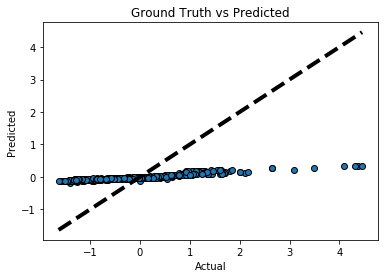

In [32]:
# From the visualization below, we can see far too many features have been removed to make the model useful. 
# It has lost all predictive value.
draw_prediction_graph(preds4)

In [34]:
#Creating a new model with L1-norm penalty of 0.1
model5 = Lasso(alpha=0.1)
model5.fit(X_train, y_train)
preds5 = model5.predict(X_test)
mse5 = mean_squared_error(preds5, y_test)
print("RMSE: %.5f" % (np.sqrt(np.abs(mse5))))

RMSE: 0.23643


In [35]:
coef5 = model5.coef_
reg5 = pd.DataFrame(list(zip(features,coef5)), columns=['feature','coef_alpha_0.1_lasso'])
reg5 = reg5.sort_values(by = 'coef_alpha_0.1_lasso', ascending=False)
reg5.head(15)

,feature,coef_alpha_0.1_lasso
6,900908-close,0.219365
4,900905-close,0.172487
48,900957-close,0.125663
36,900941-close,0.122582
16,900918-close,0.109004
27,900929-close,0.081991
45,900953-close,0.051973
41,900947-close,0.050532
32,900937-close,0.036738
9,900911-close,0.014385


In [36]:
## Most heavily weighted stocks in index construction with standardized data using sklearn.Lasso() with alpha = 0.1. 
raw_data2[raw_data2.ticker.isin([900908, 900905, 900957, 900941, 900918, 900929, 900953, 900947, 900937, 900911, 900926, 900924, 900903])][['ticker','name_b','company_name_en']]

,ticker,name_b,company_name_en
2,900903,大众B股,Dazhong Transportion Group
4,900905,老凤祥B,Lao Feng Xiang
6,900908,氯碱B股,Shanghai Chlor-Alkali Chemical
9,900911,金桥B股,Shanghai Jinqiao Development
16,900918,耀皮B股,SYP Glass Group
22,900924,上工B股,Shang Gong Group
24,900926,宝信B,Shanghai Baosight Software
27,900929,锦旅B股,Shanghai Jinjiang Travel
32,900937,华电B股,Huadian Energy
36,900941,东信B股,Eastern Communications


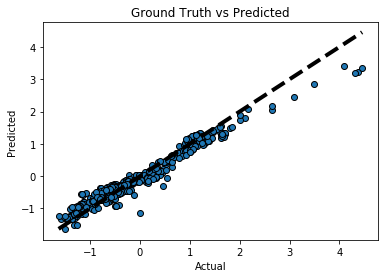

In [38]:
# We have found an acceptable model that yields fairly accurate results from a universe of only 13 stocks, with L1-norm set at 0.1. 
draw_prediction_graph(preds5)

### Index Replication Model Formulation

To build a index construction model, we take the 13 component stocks and generate a new pivot table when their daily closing price as the only predictors. We use all the data for the xgb.DMatrix.  

In [39]:
index_components = [900908, 900905, 900957, 900941, 900918, 900929, 900953, 900947, 900937, 900911, 900926, 900924, 900903]

In [40]:
df = df[df.ticker.isin(index_components)]

In [41]:
df2 = create_pivot_table(df)
df3 = df2.merge(ix, on='date')
df3.set_index('date', inplace=True)

In [42]:
# Preparing the data for XGBoost
X = df3.iloc[:,:-1]
y = np.ravel(df3.iloc[:,-1])

# Resolving infinity and None values
X.replace(np.inf, np.nan, inplace=True)
X.fillna(0, inplace=True)

In [43]:
X.head()

,900903-close,900905-close,900908-close,900911-close,900918-close,900924-close,900926-close,900929-close,900937-close,900941-close,900947-close,900953-close,900957-close
date,,,,,,,,,,,,,
2010-01-04,0.816,1.915,0.458,1.008,0.537,0.521,1.907,1.837,0.394,0.452,0.838,0.719,0.546
2010-01-05,0.833,1.932,0.460,1.000,0.542,0.524,1.934,1.862,0.397,0.459,0.840,0.739,0.542
2010-01-06,0.824,1.918,0.460,1.001,0.537,0.517,1.924,1.841,0.396,0.465,0.839,0.754,0.546
2010-01-07,0.816,1.888,0.450,0.990,0.527,0.511,1.885,1.849,0.389,0.452,0.822,0.745,0.528
2010-01-08,0.831,1.890,0.451,1.017,0.528,0.515,1.897,1.892,0.392,0.000,0.828,0.750,0.528


In [44]:
# We achieve RMSE of 25 with the parsimonious model and 13 estimators. 
dmatrix = xgb.DMatrix(data=X, label=y)
model_final = xgb.XGBRegressor(dtrain=dmatrix, booster='gblinear', n_estimators=13, reg_alpha=0.1, objective="reg:squarederror")
model_final.fit(X, y)
preds_final = model_final.predict(X)
mse_final = mean_squared_error(preds_final, y)
print("RMSE: %.5f" % (np.sqrt(np.abs(mse_final))))

RMSE: 25.05806


In [49]:
# Converting the DMatrix feauture names into a Series of integers for dataframe merging
stock = dmatrix.feature_names
tickers = [re.findall(r'\d+', s) for s in stock]
tickers_flattened = [val for sublist in tickers for val in sublist]
tickers = list(map(int, tickers_flattened))

In [50]:
coef_final = model_final.coef_
reg_final = pd.DataFrame(list(zip(tickers,coef_final)), columns=['ticker','coef'])
reg_final = reg_final.sort_values(by = 'coef', ascending=False)
reg_final

,ticker,coef
3,900911,18.49040
1,900905,17.13490
0,900903,15.54680
6,900926,15.26220
7,900929,14.20140
2,900908,13.78250
5,900924,13.54960
4,900918,12.89670
12,900957,12.31600
11,900953,12.12020


In [51]:
model_final.intercept_

array([75.951])

### Index Replication Model

Index = 
        75.95 
            + price 金桥B股(900911) * 18.49
            + price 老凤祥B(900905) * 17.13
            + price 大众B股(900903) * 15.55
            + price 宝信B  (900926) * 15.26
            + price 锦旅B股(900929) * 14.20
            + price 氯碱B股(900908) * 13.78
            + price 上工B股(900924) * 13.54
            + price 耀皮B股(900918) * 12.90
            + price 凌云B股(900957) * 12.32
            + price 凯马B  (900953) * 12.12
            + price 东信B股(900941) * 10.42
            + price 振华B股(900947) * 9.49
            + price 华电B股(900937) * 6.90


In [52]:
df_final = df.merge(reg_final, on='ticker')
df_final = df_final.assign(index_replicated = df_final['close'].mul(df_final['coef']))
df_final.tail()

,date,ticker,close,coef,index_replicated
38539,2019-11-25,900957,0.560,12.316,6.896960
38540,2019-11-26,900957,0.539,12.316,6.638324
38541,2019-11-27,900957,0.548,12.316,6.749168
38542,2019-11-28,900957,0.543,12.316,6.687588
38543,2019-11-29,900957,0.530,12.316,6.527480


In [55]:
daily = df_final.groupby('date')['index_replicated'].sum().add(75.95).to_frame()
daily = daily.merge(ix, on='date') # Merging with actual index values
daily.head()

,date,index_replicated,close
0,2010-01-04,287.927391,252.026
1,2010-01-05,290.088827,255.397
2,2010-01-06,289.327383,254.659
3,2010-01-07,286.762780,250.791
4,2010-01-08,284.502126,253.748


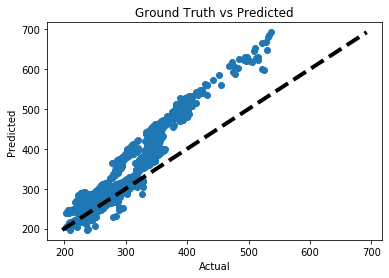

In [56]:
fig, ax = plt.subplots()
ax.scatter(daily['close'], daily['index_replicated'])
ax.plot([daily['index_replicated'].min(), daily['index_replicated'].max()], [daily['index_replicated'].min(), daily['index_replicated'].max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

We observe a severe upward bias in our model, suggesting that a uniform set of index conponents is not suitable over the ten-year period of data, and that some periodic index-recalibration methodology is needed. As a further study, the author proposes to map the changes in regression coefficients over a rolling year-long window.  

### Conclusions:

(1) Two L1-Regularized Regression Models (XGBRegressor (alpha=0.8) and sklearn.linear_model.Lasso) lead to unexpected feature selection of the component stocks of a market-capitalization/ floating-shares-weighted market index. Several of the selected stocks rank low in terms of both market cap and float. This suggests that stock-price/ index-value correlation may be influencing the model weighting. 

(2) XGBRegressor L1-Regularization with alpha values close to 1.0 does not lead to sparcification of the predictor-space as it does with sklearn Lasso regression. 

(3) Lasso regression with a high L1-norm penalty leads to very poor predictivity under StandardScaling. 

(4) Extracting regression coefficients with XGBRegressor from a subset of features derived from Lasso regression leads to upward model prediction bias in this experiment. 

### Sources

http://quotes.money.163.com
https://xgboost-clone.readthedocs.io/en/latest/parameter.html#learning-task-parameters
https://www.datacamp.com/courses/extreme-gradient-boosting-with-xgboost
https://machinelearningmastery.com/prepare-data-machine-learning-python-scikit-learn/
https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
